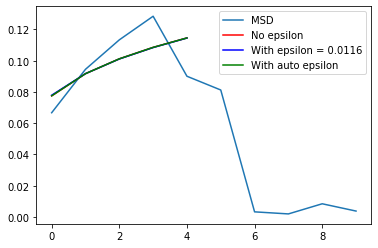

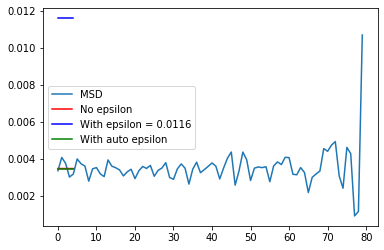

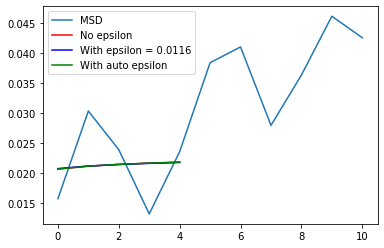

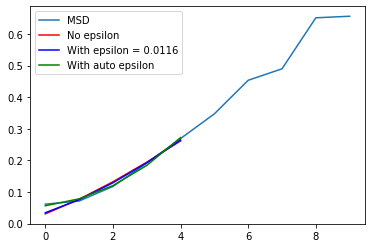

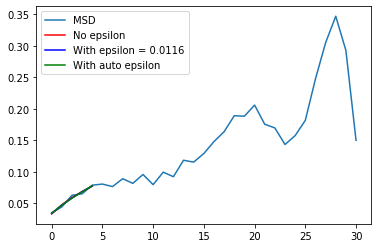

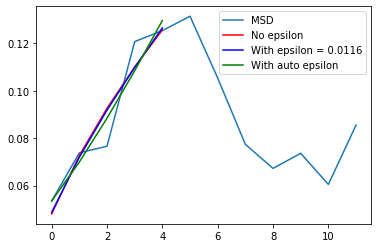

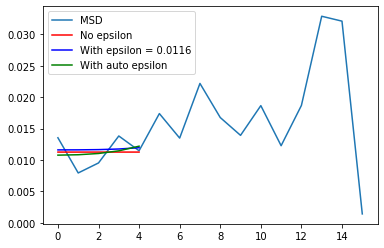

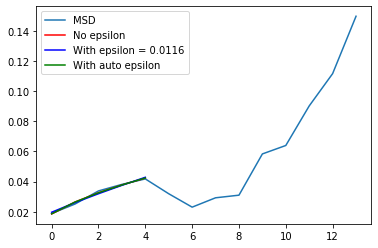

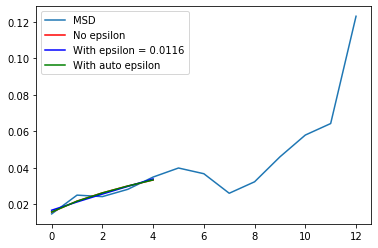

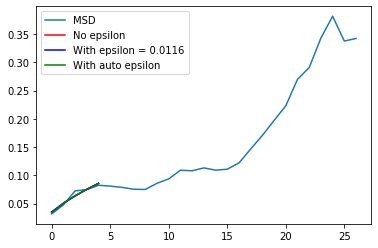

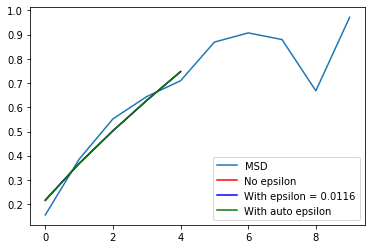

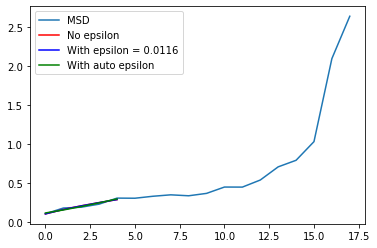

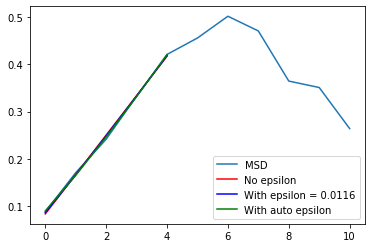

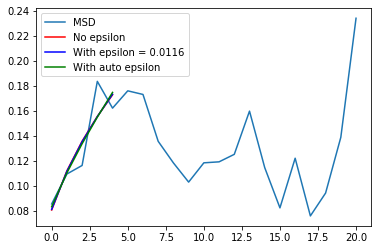

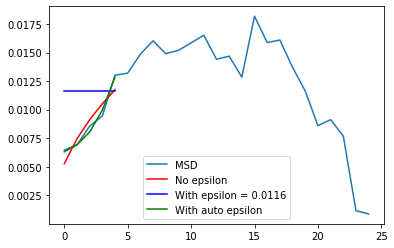

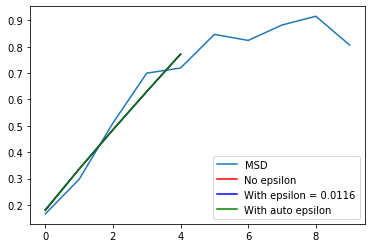

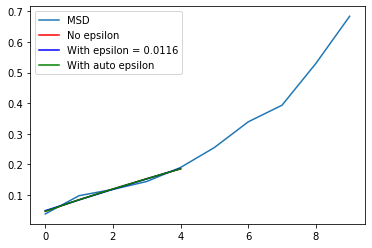

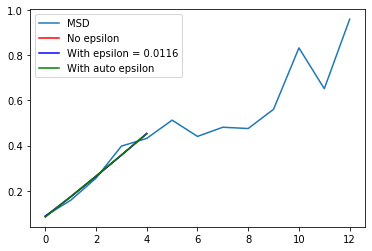

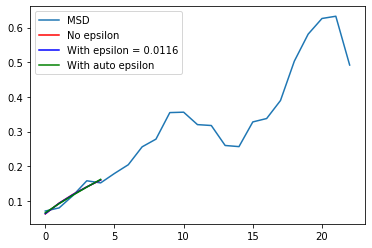

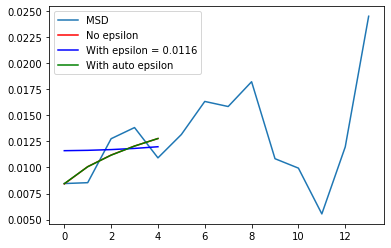

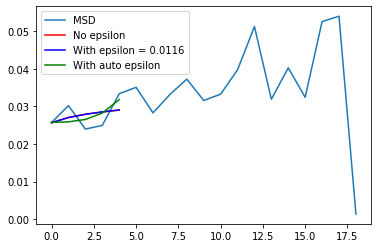

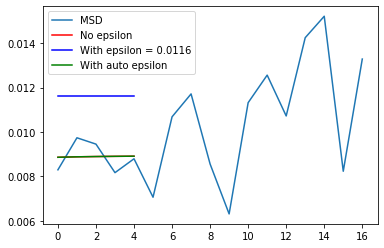

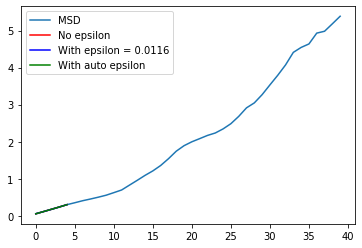

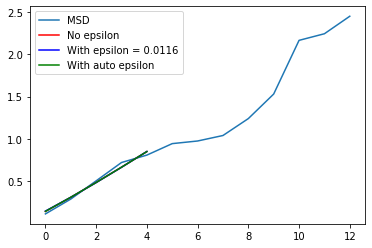

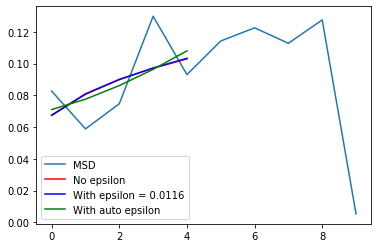

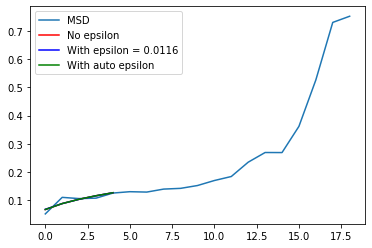

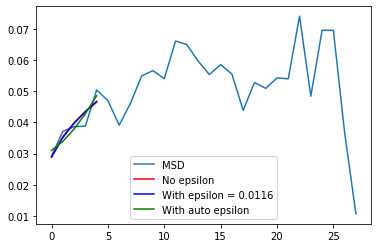

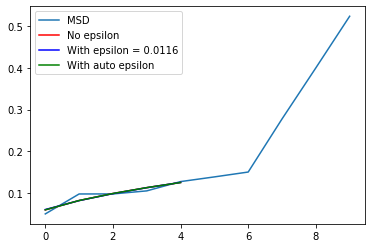

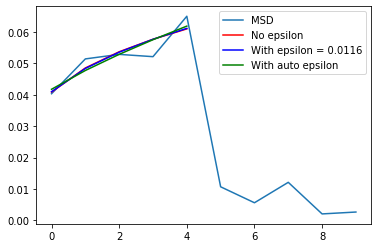

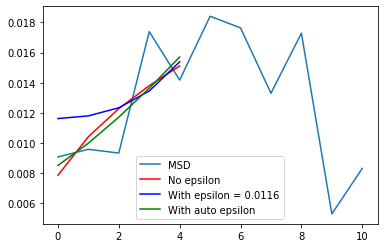

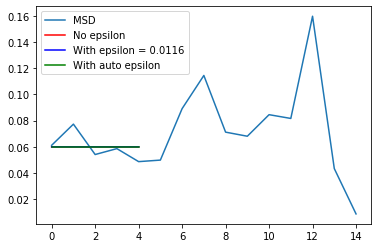

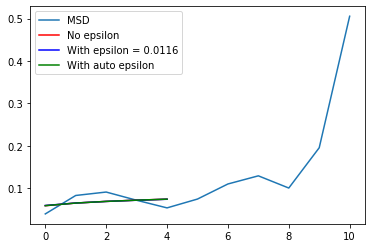

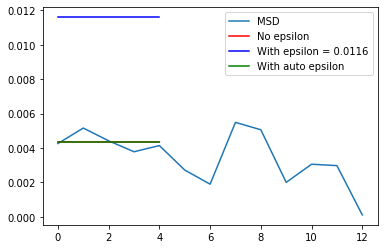

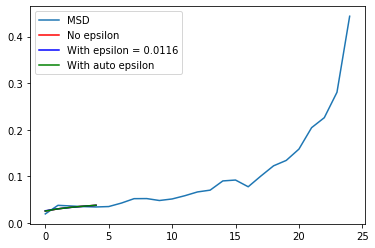

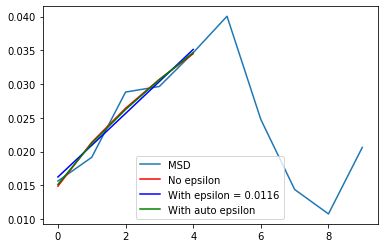

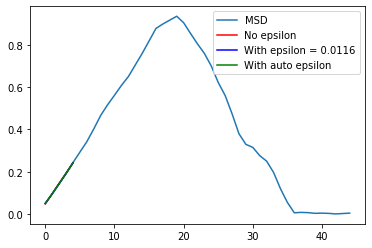

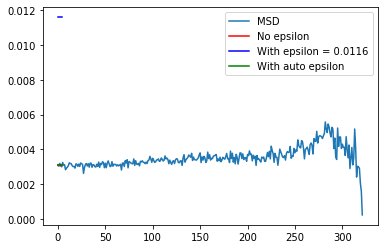

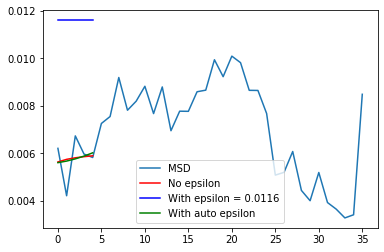

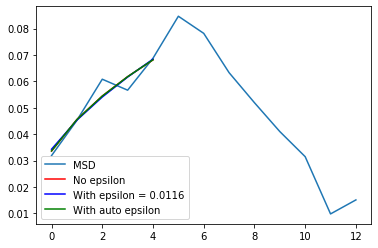

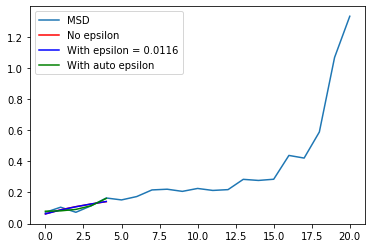

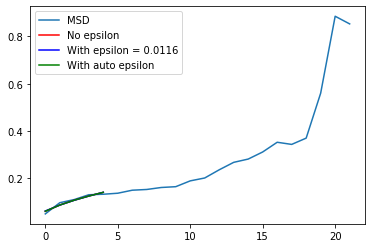

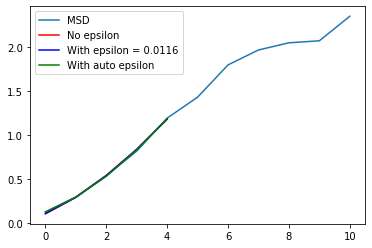

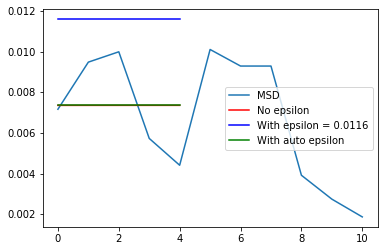

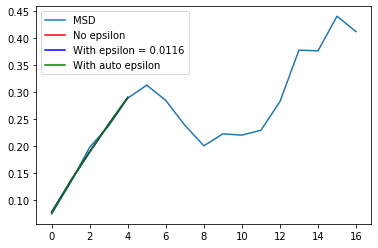

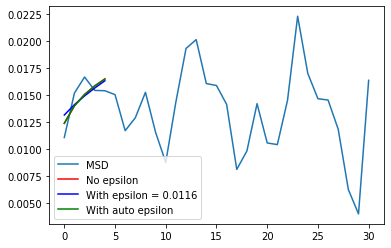

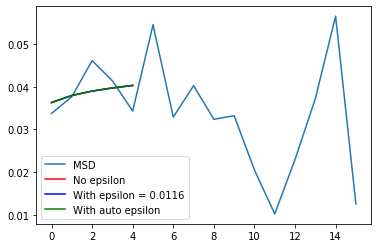

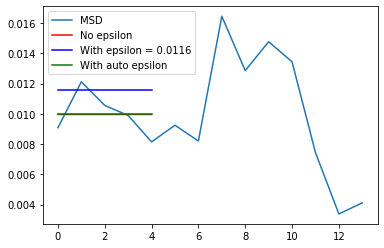

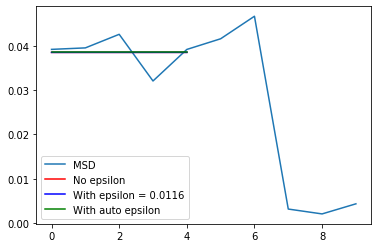

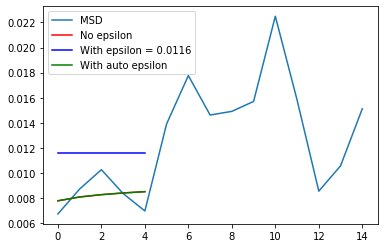

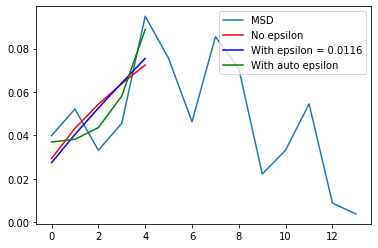

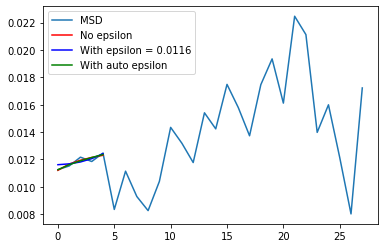

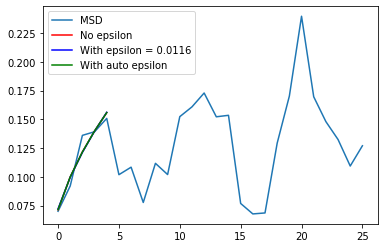

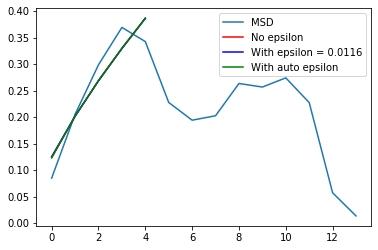

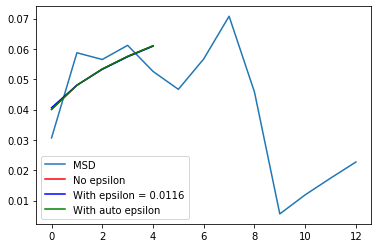

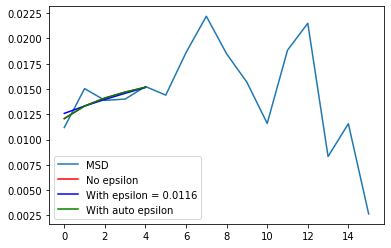

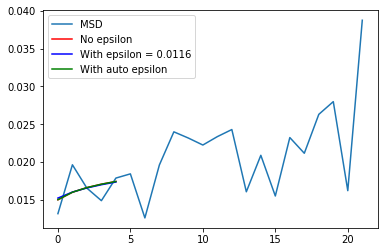

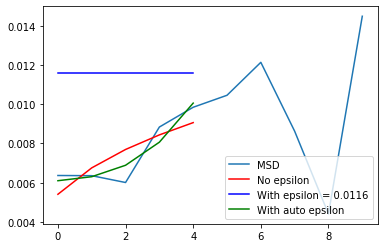

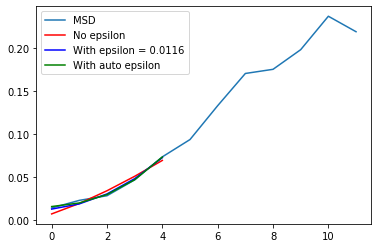

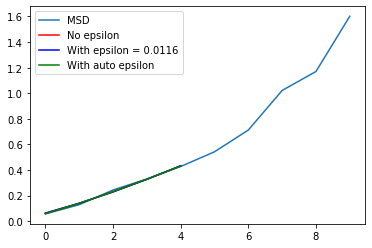

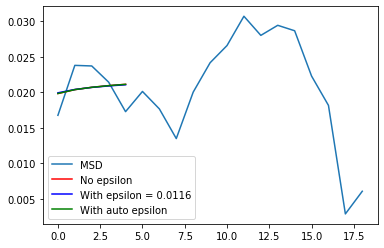

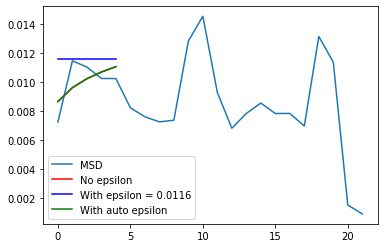

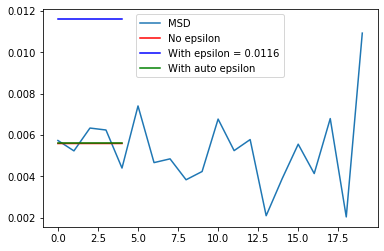

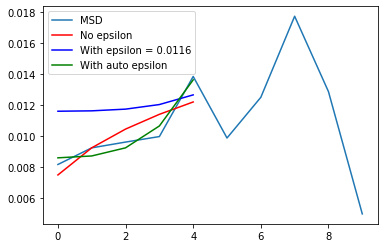

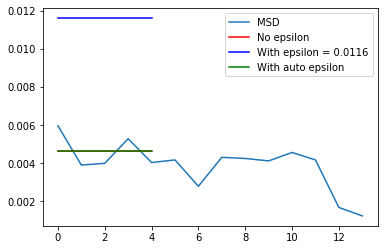

In [19]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
%matplotlib inline

def msd_epsilon(t, D, alpha,epsilon):
    """2D MSD: 4*D*t**alpha + epsilon"""
    return(4*D*t**alpha+epsilon)


def msd(t,D,alpha):
    return(4*D*t**alpha)

def msd_fixed(t,D,alpha):
    return(4*D*t**alpha+0.0116)


filename = "Data/sm3.csv"
data = pd.read_csv(filename) 
tracklist = data.TRACK_ID.unique()  
dt = 0.05  

minframe = 10
maxframe = 500

minalpha = 1.0E-04
minD = 1.0E-08
maxD = 4
maxalpha = 4
        
alphaD = []
rhoens_alltracks = []    #empty array that will contain the list of rho_n for each track
reduced_linear_data = []
total_tracks=0
anomalous_percentage=0

for tid in tracklist:
    
    trackid = data["TRACK_ID"] == tid
    x = data[trackid]["POSITION_X"].to_numpy()   #x associated to track 'tid'
    y = data[trackid]["POSITION_Y"].to_numpy()   #y associated to track 'tid'
    intensity = data[trackid]["MEAN_INTENSITY"].to_numpy()
    
    frame_alldata.append(len(x))

    rhon = []#list of rho_n for a given track
    if len(x)<maxframe and len(x)>minframe:
        for n in range(1,len(x)):             #for each n = each time lag
            s = 0
            for i in range(0,len(x)-n):
                s+=(x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
            rhon.append(1/(len(x)-n)*s)         #rho_n = 1/(N-n) * sum_i (r[i+n] - r[i])^2 
        
        N = len(rhon)+1
        t = [n*dt for n in np.linspace(1,N-1,N-1)]
        nbrpts = 4 #int(0.3*N)
        
        
        model = Model(msd)
        params = Parameters()
        params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
        params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)
        result = model.fit(rhon[:nbrpts+1], params, t=t[:nbrpts+1])

        plt.plot(rhon,label="MSD")
        
        model_epsilon = Model(msd_epsilon)
        params2 = Parameters()
        params2['epsilon'] = Parameter(name='epsilon', value=0.05, min=0.001, max=0.2)
        params2['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
        params2['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)
        result_epsilon = model_epsilon.fit(rhon[:nbrpts+1], params2, t=t[:nbrpts+1])
        
        model_fixed = Model(msd_fixed)
        params_fixed = Parameters()
        params_fixed['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
        params_fixed['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)
        result_fixed = model_fixed.fit(rhon[:nbrpts+1], params_fixed, t=t[:nbrpts+1])        
        
        plt.plot(result.best_fit,"r",label="No epsilon")
        plt.plot(result_fixed.best_fit,"b",label="With epsilon = 0.0116")
        plt.plot(result_epsilon.best_fit,"g",label="With auto epsilon")
        plt.legend()
        plt.savefig("Result/MSD_fits/msd"+str(tid)+".png")
        plt.show()
